# For this task:
* Choose a dataset from the provided list
* Explore/clean the data
* Exploratory Visualizations
    * Creating exploratory visualizations to understand your data and search for trends.
* Choose a model
    * Preprocess data
    * Fit and evaluate a default model
    * Extract and visualize the top 10 features using permutation importance (from Intro to ML Week 4)
    * Add your observations in a Markdown: Do these features make sense based on the business case?
* Create Explanatory Visualizations for the most important features.
    * Select 2 out of the top 10 features from your permutation importances and produce explanatory visualizations showing the relationship between the feature and the target.
    * The purpose is to demonstrate key trends you found that will be of interest to a stakeholder.
        * These visuals should be reporting-quality with titles, labels, and a short explanation of the trend. Be sure to explain in a text cell the insight associated with each visual. Both of these visualizations should be easily understood by a non-technical audience (Neither of these should be histograms, boxplots, or correlation plots).
        * These will be added to your readme in part 4

---

# Context
Cirrhosis is a late stage of scarring (fibrosis) of the liver caused by many forms of liver diseases and conditions, such as hepatitis and chronic alcoholism. The following data contains the information collected from the Mayo Clinic trial in primary biliary cirrhosis (PBC) of the liver conducted between 1974 and 1984. A description of the clinical background for the trial and the covariates recorded here is in Chapter 0, especially Section 0.2 of Fleming and Harrington, Counting
Processes and Survival Analysis, Wiley, 1991. A more extended discussion can be found in Dickson, et al., Hepatology 10:1-7 (1989) and in Markus, et al., N Eng J of Med 320:1709-13 (1989).

A total of 424 PBC patients, referred to Mayo Clinic during that ten-year interval, met eligibility criteria for the randomized placebo-controlled trial of the drug D-penicillamine. The first 312 cases in the dataset participated in the randomized trial and contain largely complete data. The additional 112 cases did not participate in the clinical trial but consented to have basic measurements recorded and to be followed for survival. Six of those cases were lost to follow-up shortly after diagnosis, so the data here are on an additional 106 cases as well as the 312 randomized participants.

Attribute Information
1) ID: unique identifier
2) N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986
3) Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)
4) Drug: type of drug D-penicillamine or placebo
5) Age: age in [days]
6) Sex: M (male) or F (female)
7) Ascites: presence of ascites N (No) or Y (Yes)
8) Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)
9) Spiders: presence of spiders N (No) or Y (Yes)
10) Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)
11) Bilirubin: serum bilirubin in [mg/dl]
12) Cholesterol: serum cholesterol in [mg/dl]
13) Albumin: albumin in [gm/dl]
14) Copper: urine copper in [ug/day]
15) Alk_Phos: alkaline phosphatase in [U/liter]
16) SGOT: SGOT in [U/ml]
17) Triglycerides: triglicerides in [mg/dl]
18) Platelets: platelets per cubic [ml/1000]
19) Prothrombin: prothrombin time in seconds [s]
20) Stage: histologic stage of disease (1, 2, 3, or 4)

---

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn import set_config
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

set_config(transform_output='pandas')
pd.set_option('display.max_columns',100)

# Functions

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

# Load Data
* [Cirrhosis Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/cirrhosis-prediction-dataset)

In [3]:
fpath="Data/archive (2).zip"
df=pd.read_csv(fpath)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


## Explore and Clean Data
- Drop ID column
- Going to check for duplicates
- Checking for NA values
    - 106 cases did not particapate in the study but consented to have basic measurements recorded and to be followed for survival
        - Are these cases useful?
- .describe() on numerical data to find outliers
- Identify columns that have binary values
    - Address these columns


In [4]:
del df['ID']
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [5]:
df.duplicated().sum()

0

- *no duplicates*

In [6]:
df.isna().sum()

N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

 - use missingno to get a better view of the NA's

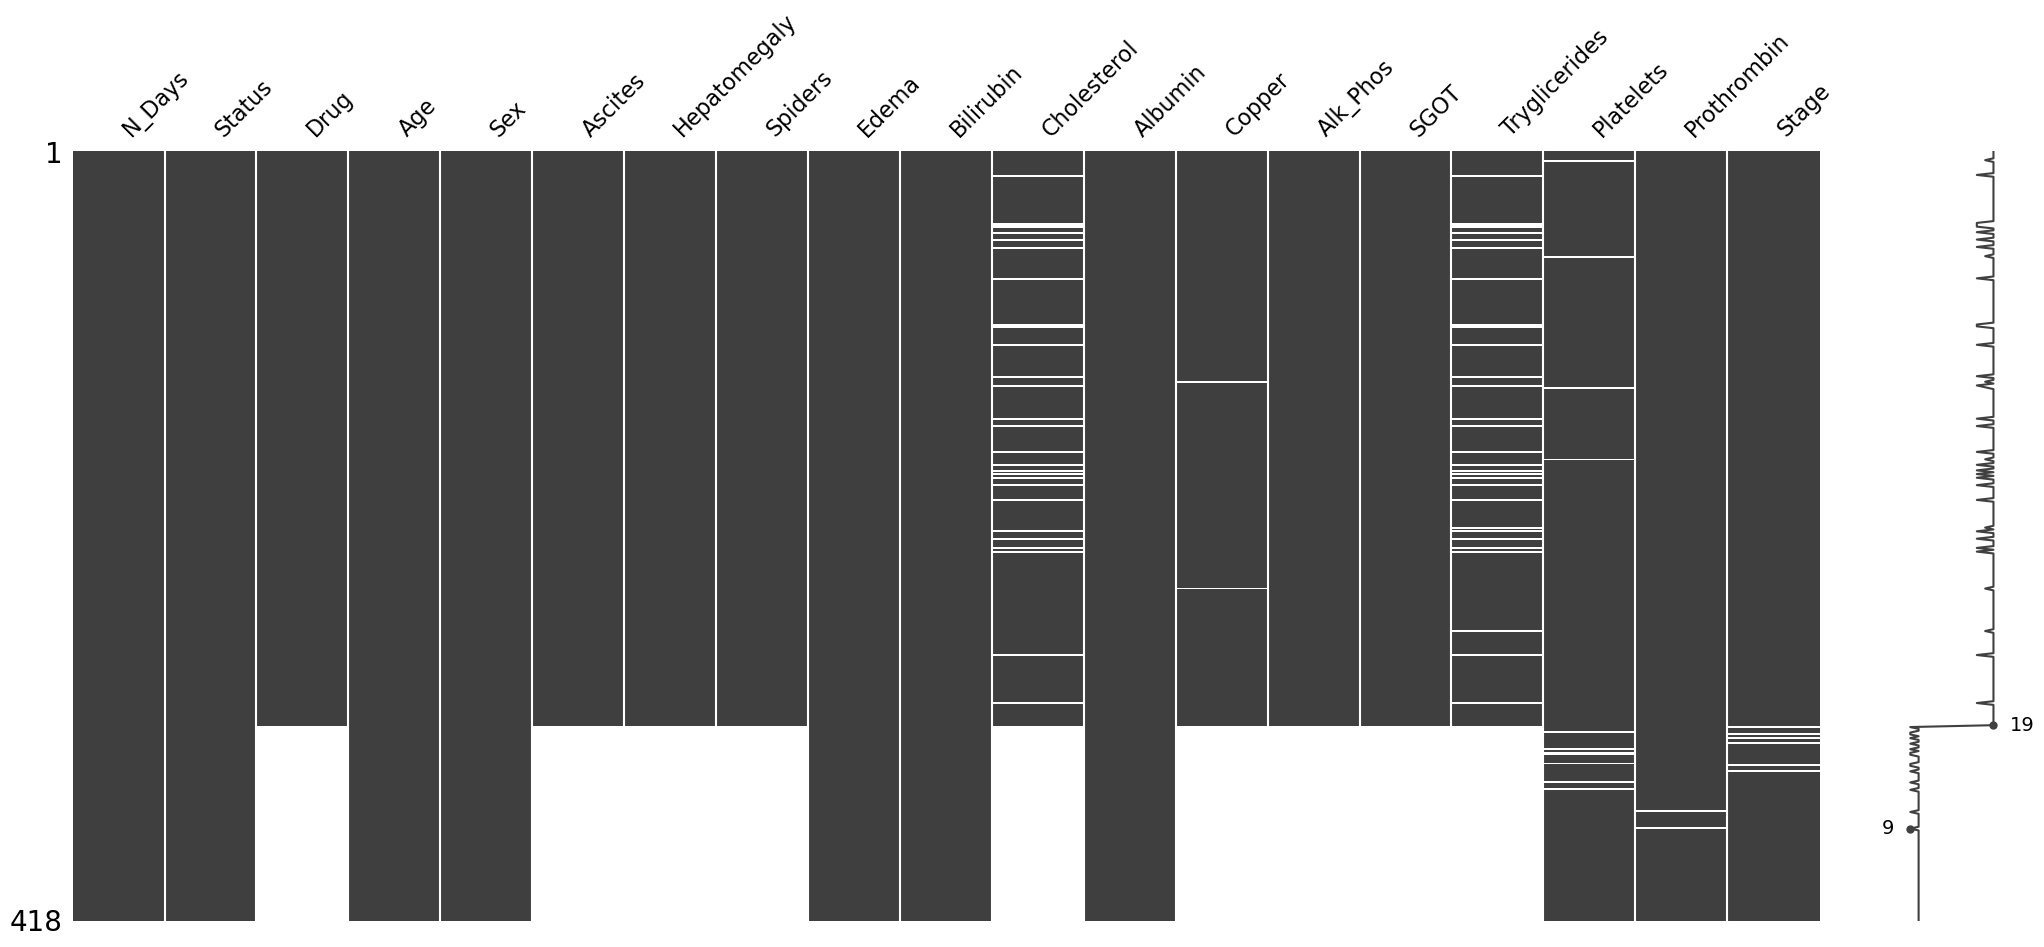

In [7]:
missingno.matrix(df);

- Decided to drop the group of 106 non-participants

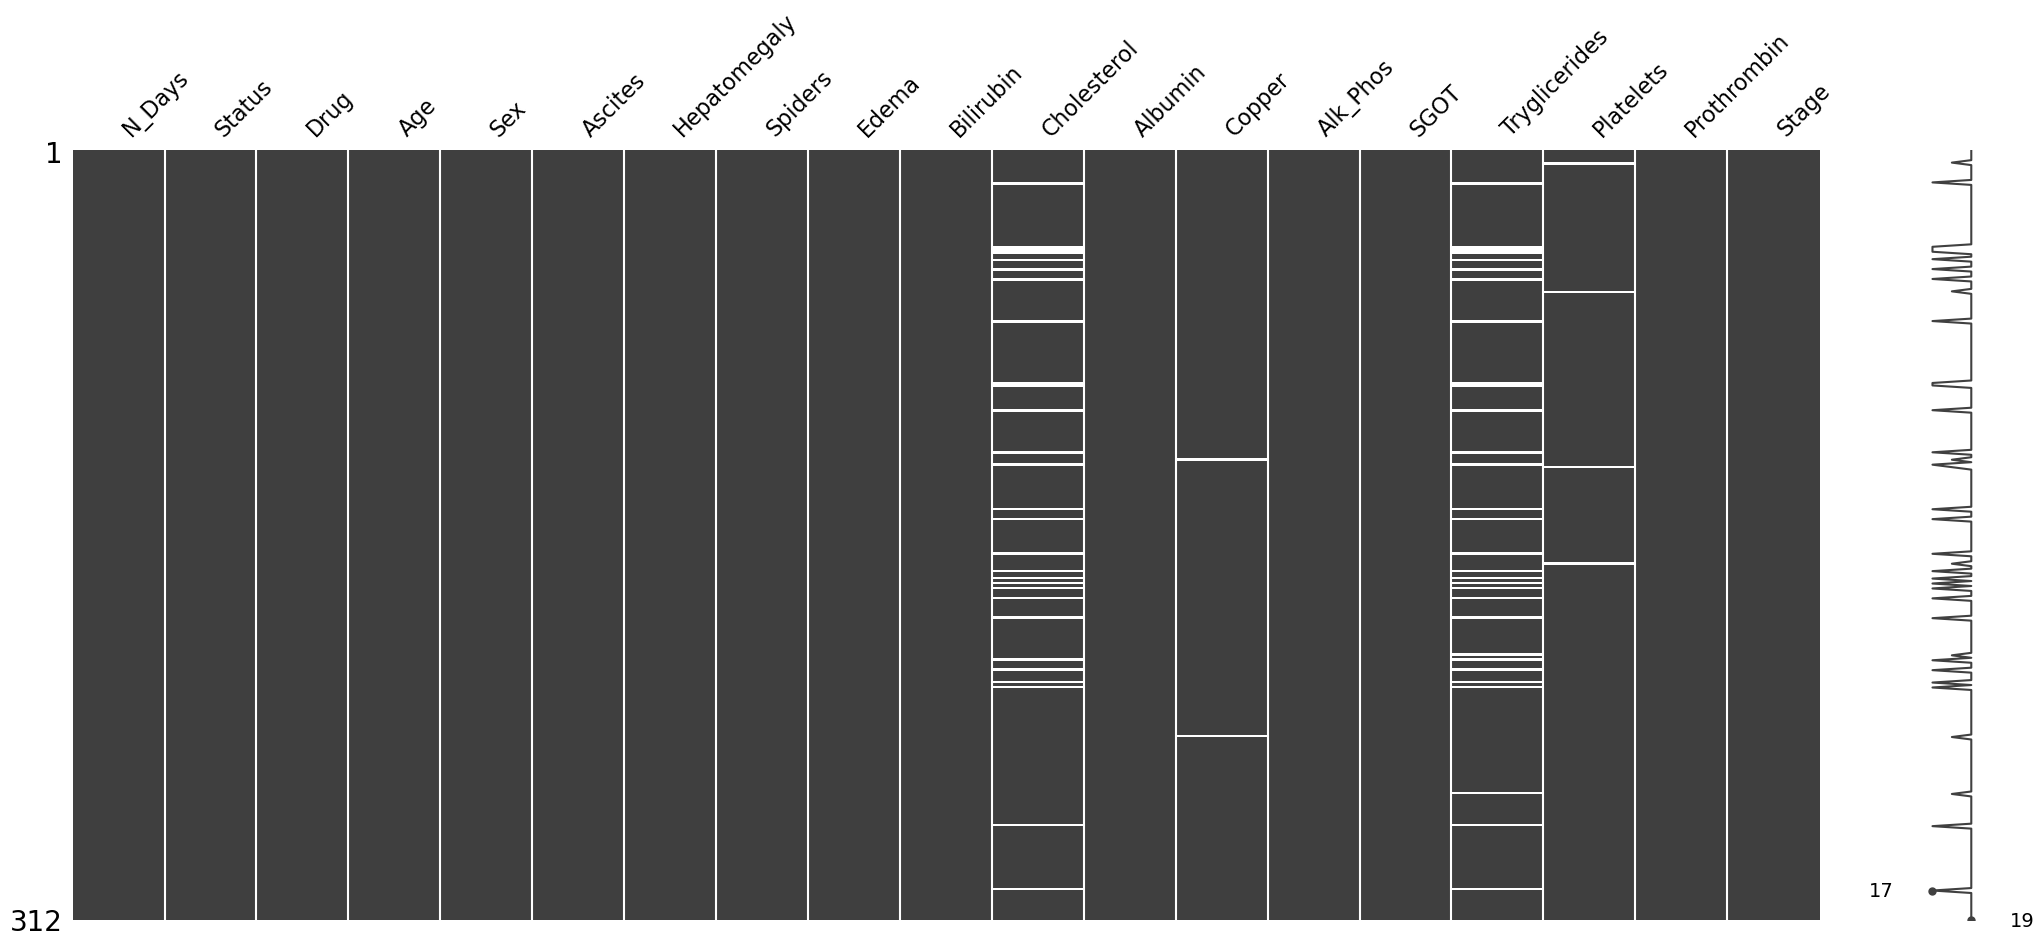

In [8]:
df=df.dropna(subset=['Drug'])
missingno.matrix(df);

# Will use simple imputer to fill the rest of the NA with median

In [10]:
df.describe(exclude='number')

,Status,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema
count,312,312,312,312,312,312,312
unique,3,2,2,2,2,2,3
top,C,D-penicillamine,F,N,Y,N,N
freq,168,158,276,288,160,222,263


- Status & Edema have 3 values
    - Change to Binary
        - Status to Alive(C,CL):1 OR Died(D):0
        - Edema to Y(Y):1 OR N(S,N):0

In [11]:
df['Status'].value_counts()

C     168
D     125
CL     19
Name: Status, dtype: int64

In [35]:
df['Status'] = df['Status'].replace({'C':1,'CL':1,"D":0})
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,0,1,59,0,1,1,1,Y,2.674149,5.564520,2.60,5.049856,7.448916,4.926891,5.147494,190.0,2.501436,4.0
1,4500,1,1,57,0,0,1,1,N,0.095310,5.710427,4.14,3.988984,8.908532,4.731979,4.477337,221.0,2.360854,3.0
2,1012,0,1,71,1,0,0,0,S,0.336472,5.170484,3.48,5.347108,6.246107,4.565389,4.007333,151.0,2.484907,4.0
3,1925,0,1,55,0,0,1,1,S,0.587787,5.497168,2.54,4.158883,8.719611,4.104790,4.521789,183.0,2.332144,4.0
4,1504,1,0,38,0,0,1,1,N,1.223775,5.631212,3.53,4.962845,6.508769,4.728714,4.276666,136.0,2.388763,3.0


In [12]:
df['Edema'].value_counts(dropna=False)

N    263
S     29
Y     20
Name: Edema, dtype: int64

In [37]:
df['Edema'] = df['Edema'].replace({'N':0,'S':0,'Y':1})
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,0,1,59,0,1,1,1,1,2.674149,5.564520,2.60,5.049856,7.448916,4.926891,5.147494,190.0,2.501436,4.0
1,4500,1,1,57,0,0,1,1,0,0.095310,5.710427,4.14,3.988984,8.908532,4.731979,4.477337,221.0,2.360854,3.0
2,1012,0,1,71,1,0,0,0,0,0.336472,5.170484,3.48,5.347108,6.246107,4.565389,4.007333,151.0,2.484907,4.0
3,1925,0,1,55,0,0,1,1,0,0.587787,5.497168,2.54,4.158883,8.719611,4.104790,4.521789,183.0,2.332144,4.0
4,1504,1,0,38,0,0,1,1,0,1.223775,5.631212,3.53,4.962845,6.508769,4.728714,4.276666,136.0,2.388763,3.0


- What are the values of 'Drug'

## Binary Encoding

In [13]:
df['Drug'].value_counts()

D-penicillamine    158
Placebo            154
Name: Drug, dtype: int64

In [14]:
df = df.replace({'F':0,'M':1,'D-penicillamine':1,'Placebo':0})
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,1,21464,0,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,1,20617,0,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,1,25594,1,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,1,19994,0,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,CL,0,13918,0,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [15]:
yn_col=['Ascites','Hepatomegaly','Spiders']
df[yn_col] = df[yn_col].replace({'Y':1,"N":0})
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,1,21464,0,1,1,1,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,1,20617,0,0,1,1,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,1,25594,1,0,0,0,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,1,19994,0,0,1,1,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,CL,0,13918,0,0,1,1,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


## Convert Age into Years

In [16]:
 df['Age']=df['Age']//360
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,1,59,0,1,1,1,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,1,57,0,0,1,1,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,1,71,1,0,0,0,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,1,55,0,0,1,1,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,CL,0,38,0,0,1,1,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


# Outlires
- np.log to address

In [9]:
df.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,312.000000,312.000000,312.000000,284.000000,312.000000,310.000000,312.000000,312.000000,282.000000,308.000000,312.000000,312.000000
mean,2006.362179,18269.442308,3.256090,369.510563,3.520000,97.648387,1982.655769,122.556346,124.702128,261.935065,10.725641,3.032051
std,1123.280843,3864.805407,4.530315,231.944545,0.419892,85.613920,2140.388824,56.699525,65.148639,95.608742,1.004323,0.877880
min,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1191.000000,15427.750000,0.800000,249.500000,3.310000,41.250000,871.500000,80.600000,84.250000,199.750000,10.000000,2.000000
50%,1839.500000,18187.500000,1.350000,309.500000,3.550000,73.000000,1259.000000,114.700000,108.000000,257.000000,10.600000,3.000000
75%,2697.250000,20715.000000,3.425000,400.000000,3.800000,123.000000,1980.000000,151.900000,151.000000,322.500000,11.100000,4.000000
max,4556.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,17.100000,4.000000


### Outliers (7)
- Bilirubin
- Cholesterol
- Copper
- Alk_Phos
- SGOT
- Tryglicerides
- Prothrombin

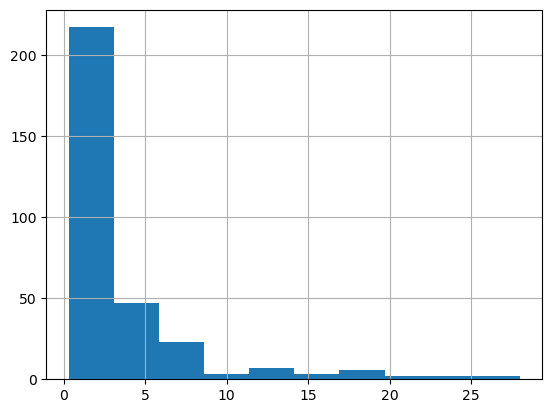

In [17]:
df["Bilirubin"].hist();

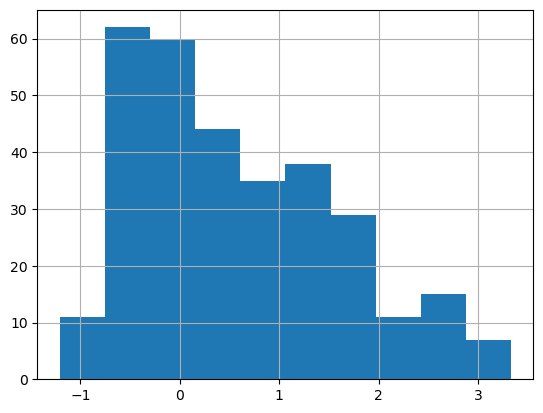

In [18]:
df['Bilirubin']=np.log(df['Bilirubin'])
df['Bilirubin'].hist();

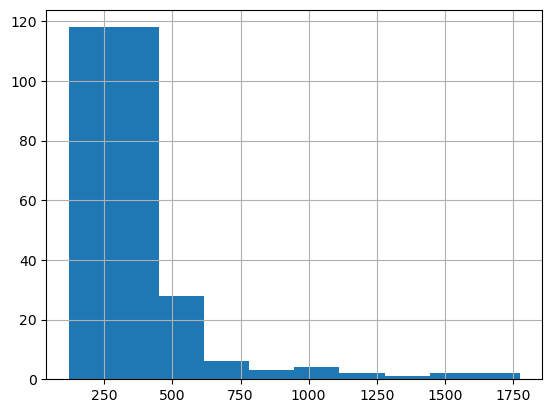

In [23]:
df['Cholesterol'].hist();

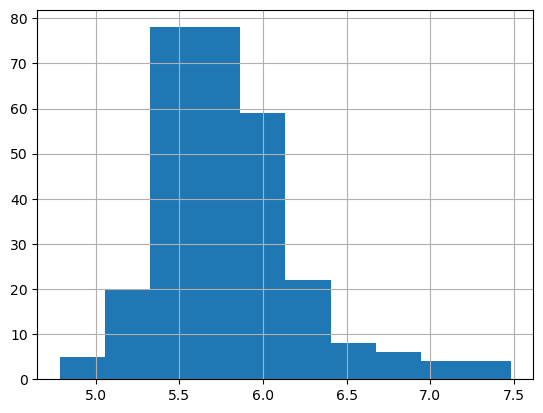

In [24]:
df['Cholesterol']=np.log(df['Cholesterol'])
df['Cholesterol'].hist();

<Axes: >

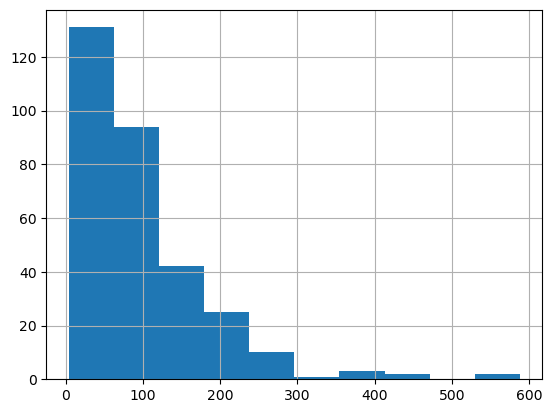

In [21]:
df['Copper'].hist();

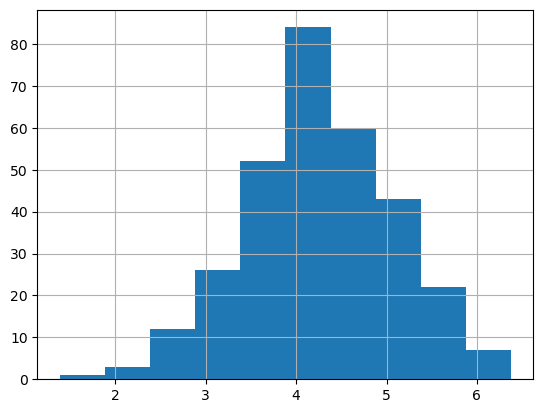

In [22]:
df['Copper']=np.log(df['Copper'])
df['Copper'].hist();

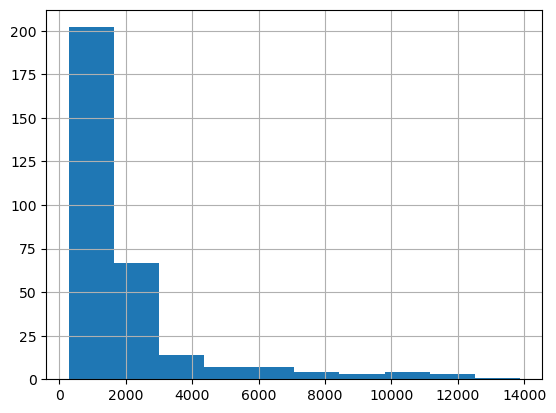

In [19]:
df['Alk_Phos'].hist();

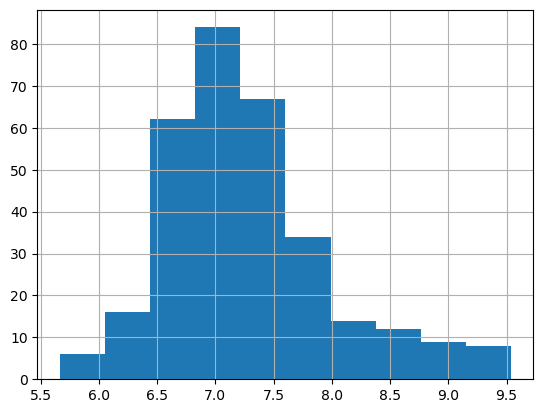

In [20]:
df['Alk_Phos']=np.log(df['Alk_Phos'])
df['Alk_Phos'].hist();

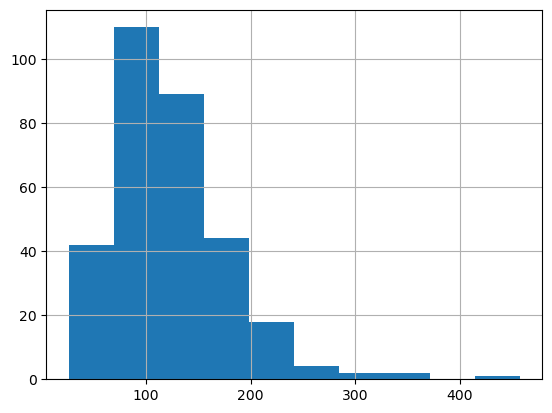

In [27]:
df['SGOT'].hist();

<Axes: >

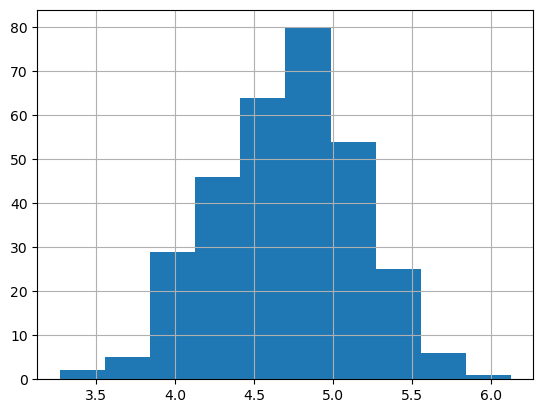

In [28]:
df['SGOT'] = np.log(df['SGOT'])
df['SGOT'].hist();

<Axes: >

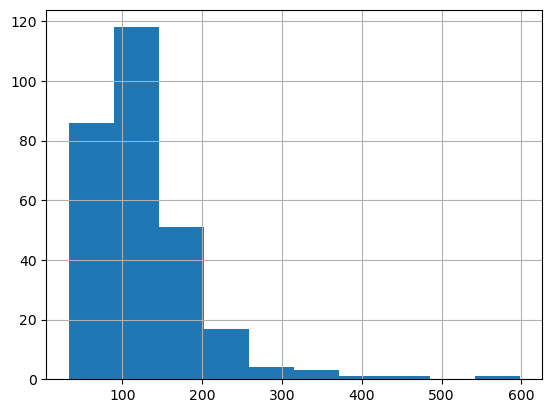

In [29]:
df['Tryglicerides'].hist();

<Axes: >

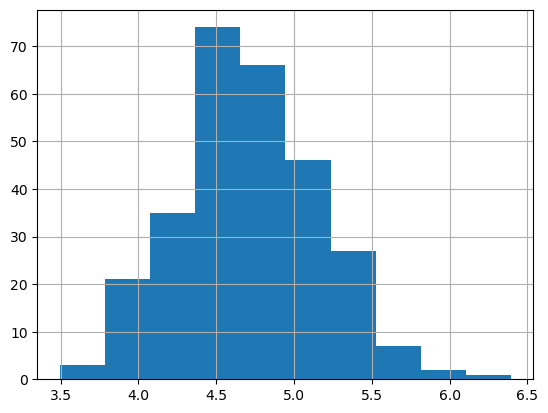

In [30]:
df['Tryglicerides'] = np.log(df['Tryglicerides'])
df['Tryglicerides'].hist();

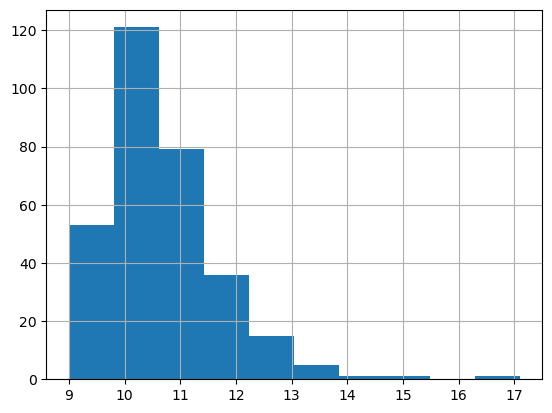

In [32]:
df['Prothrombin'].hist();

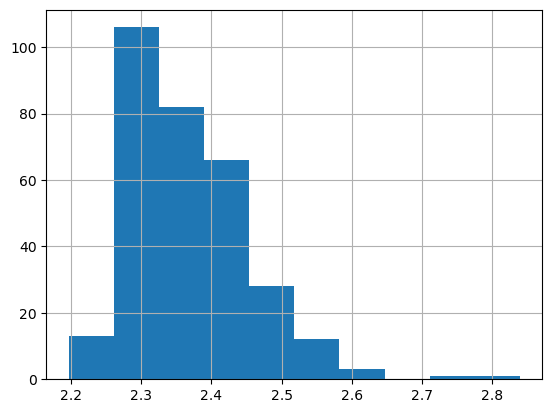

In [33]:
df['Prothrombin'] = np.log(df['Prothrombin'])
df['Prothrombin'].hist();

# TTS

In [25]:
target = 'Stage'
y = df[target].copy()
X = df.drop(columns=target)

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)
X_train.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
119,2033,CL,1,35,1,0,0,0,N,1.252763,5.783825,3.98,6.095825,6.641182,130.2,210.0,344.0,10.6
258,1615,C,0,60,0,0,1,0,N,1.131402,5.624018,2.97,3.737670,7.012115,125.0,126.0,221.0,9.8
244,1790,C,0,46,0,0,1,0,N,-0.510826,5.609472,3.65,3.871201,6.677083,52.7,214.0,305.0,9.6
204,2081,D,1,49,0,1,0,0,N,0.916291,5.945421,3.55,4.682131,7.323831,238.7,NaN,126.0,10.3
137,1297,D,1,51,1,0,1,0,N,1.987874,6.054439,3.93,5.568345,7.793174,145.7,218.0,252.0,10.5


# Numeric

In [26]:
X_train.select_dtypes('number')

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
119,2033,1,35,1,0,0,0,1.252763,5.783825,3.98,6.095825,6.641182,130.20,210.0,344.0,10.6
258,1615,0,60,0,0,1,0,1.131402,5.624018,2.97,3.737670,7.012115,125.00,126.0,221.0,9.8
244,1790,0,46,0,0,1,0,-0.510826,5.609472,3.65,3.871201,6.677083,52.70,214.0,305.0,9.6
204,2081,1,49,0,1,0,0,0.916291,5.945421,3.55,4.682131,7.323831,238.70,NaN,126.0,10.3
137,1297,1,51,1,0,1,0,1.987874,6.054439,3.93,5.568345,7.793174,145.70,218.0,252.0,10.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,2456,0,51,0,0,1,0,0.262364,5.886104,3.63,3.951244,7.502186,97.65,164.0,256.0,9.9
71,4184,0,32,0,0,0,0,-0.693147,5.768321,3.54,3.931826,7.125283,122.45,80.0,225.0,10.0
106,3388,0,63,0,0,0,0,-0.510826,5.356586,4.03,2.302585,6.473891,71.30,77.0,316.0,17.1
270,1569,0,51,0,0,1,0,0.000000,5.771441,3.50,4.543295,6.861711,111.00,177.0,289.0,9.7
